In [53]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
from datetime import date
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# no warnings
import warnings
warnings.filterwarnings('ignore')

In [54]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "outcome_type"

In [55]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [56]:
classes = train[label].unique().tolist()
print(f"Label classes: {classes}")

train[label] = train[label].map(classes.index)

Label classes: ['adoption', 'no outcome', 'transfer']


In [57]:
train.columns

Index(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'outcome_type', 'sex',
       'spay_neuter'],
      dtype='object')

In [58]:
test.columns

Index(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'sex', 'spay_neuter'],
      dtype='object')

# Train

In [59]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(dataset[col].mean())
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

In [60]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    banned = ['brindle',
    'tabby',
    'merle',
    'torbie',
    'point',
    'smoke',
    'tiger',
    'tick'
    ]
    
    # Colors
    dataset['color'] = dataset['color'].str.lower()
    dataset['color'] = np.where(dataset['color'] == 'Tortie', 'Torbie', dataset['color'])
    
   # dataset['color_type'] = None
   # dataset['color_type'] = np.where(dataset['color'].str.contains('brindle'), "brindle", dataset['color_type'])
   # dataset['color_type'] = np.where(dataset['color'].str.contains('tabby'), "tabby", dataset['color_type'])
  #  dataset['color_type'] = np.where(dataset['color'].str.contains('merle'), "merle", dataset['color_type'])
   # dataset['color_type'] = np.where(dataset['color'].str.contains('torbie'), "torbie", dataset['color_type'])
   # dataset['color_type'] = np.where(dataset['color'].str.contains('point'), "point", dataset['color_type'])
   # dataset['color_type'] = np.where(dataset['color'].str.contains('smoke'), "smoke", dataset['color_type'])
   # dataset['color_type'] = np.where(dataset['color'].str.contains('tiger'), "tiger", dataset['color_type'])
  #  dataset['color_type'] = np.where(dataset['color'].str.contains('tick'), "tick", dataset['color_type'])
    
    dataset['num_colors'] = dataset['color'].str.split('/').str.len()
  #  dataset['color_one'] = dataset['color'].apply(lambda x: x.split('/')[0])
  #  dataset['color_two'] = dataset['color'].apply(lambda x: x.split('/')[1] if len(x.split('/')) > 1 else 'None')
  #  dataset['color_two'] = np.where(dataset['color_two'] == 'None', dataset['color_one'],dataset['color_two'])
    
    #dataset['color_one'] = dataset['color_one'].str.replace('/',' ')
    #dataset['color_one'] = [' '.join([item for item in x.split() 
    #                   if item not in banned]) 
    #                   for x in dataset["color_one"]]

  #  dataset['color_two'] = dataset['color_two'].str.replace('/',' ')
  #  dataset['color_two'] = [' '.join([item for item in x.split() 
   #                    if item not in banned]) 
  #                     for x in dataset["color_two"]]\
  #  
   # dataset['num_colors'] = np.where((dataset['color_one'] == 'tricolor') | (dataset['color_two'] == 'tricolor'), 3, dataset['num_colors'])
    
    # Breeds
    dataset['breed'] = dataset['breed'].str.lower()
    
    #dataset['breed_one'] = dataset['breed'].apply(lambda x: x.split('/')[0])
    #dataset['breed_two'] = dataset['breed'].apply(lambda x: x.split('/')[1] if len(x.split('/')) ==2 else 'None')
    #dataset['breed_three'] = dataset['breed'].apply(lambda x: x.split('/')[2] if len(x.split('/')) ==3 else 'None')
    #dataset['breed_two'] = np.where(dataset['breed_two'] == 'None', dataset['breed_one'],dataset['breed_two'])
    #dataset['breed_three'] = np.where(dataset['breed_three'] == 'None', dataset['breed_one'],dataset['breed_three'])
    
    dataset['num_breed'] = dataset['breed'].str.split('/').str.len()
   # dataset['mixed'] = np.where(dataset['breed'].str.contains('mix'), 1,0)
   # dataset['mixed'] = np.where(dataset['num_breed'] > 1, 1 ,dataset['mixed'])
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

In [61]:
train

,id,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_type,sex,spay_neuter,num_colors,num_breed
0,1265,2 years,Cat,russian blue mix,blue,2014-04-21,2016-08-05 14:15:00,Smokey,0,Male,Fixed,1,1
1,24053,1 year,Other,bat mix,brown,2016-10-24,2017-10-25 08:02:00,NaN,1,Unknown,Unknown,1,1
2,4785,2 months,Dog,chihuahua shorthair/pomeranian,brown,2014-01-04,2014-03-08 16:37:00,NaN,2,Female,Fixed,1,2
3,65439,2 years,Cat,domestic shorthair mix,brown tabby/white,2012-11-26,2014-12-04 12:21:00,Momma Kitty,2,Female,Fixed,2,1
4,45732,1 year,Dog,rat terrier mix,white/chocolate,2014-07-10,2016-01-16 16:46:00,Estrella,2,Female,Fixed,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54403,48705,6 months,Dog,basset hound mix,brown brindle/white,2016-05-01,2016-11-06 17:53:00,*Mobey,0,Male,Fixed,2,1
54404,42473,8 years,Dog,pointer/labrador retriever,white/black,2006-09-16,2014-09-27 14:40:00,Daisy,0,Female,Fixed,2,2
54405,57001,4 months,Cat,domestic shorthair mix,white/orange tabby,2014-04-07,2014-08-23 16:51:00,French Fry,2,Male,Fixed,2,1
54406,74609,3 years,Cat,domestic medium hair mix,calico,2013-07-07,2016-08-10 18:43:00,Orangee,0,Female,Fixed,1,1


In [89]:
X_train.shape

(43526, 2)

In [90]:
X_train[X_train['outcome_type'] == 0].shape[0]/X_train.shape[0]

0.6118641731378945

In [91]:
X_train[X_train['outcome_type'] == 1].shape[0]/X_train.shape[0]

0.08656894729586914

In [92]:
X_train[X_train['outcome_type'] == 2].shape[0]/X_train.shape[0]

0.3015668795662363

In [62]:
def computation_transforms(dataset):
    """ 
    New Feature Engineering. Default, None...
    """
    
    # Date stuff
    dataset['datetime'] = pd.to_datetime(dataset['datetime'])
    dataset['year'] = dataset['datetime'].dt.year
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.day
    dataset['hour'] = dataset['datetime'].dt.hour
    dataset['weekday'] = dataset['datetime'].dt.day_name()
    
    #age
    dataset['date_of_birth'] = pd.to_datetime(dataset['date_of_birth'])
    dataset['age'] = (dataset['datetime'] - dataset['date_of_birth']).dt.days
    dataset['birth_year'] = dataset['date_of_birth'].dt.year
    dataset['birth_month'] = dataset['date_of_birth'].dt.month
    # color??
    return dataset

train = computation_transforms(train)
test = computation_transforms(test)

In [63]:
train['breed_set'] = train['breed'].str.split()
test['breed_set'] = test['breed'].str.split()

# Train

In [64]:
train.head(1)

,id,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_type,sex,...,num_breed,year,month,day,hour,weekday,age,birth_year,birth_month,breed_set
0,1265,2 years,Cat,russian blue mix,blue,2014-04-21,2016-08-05 14:15:00,Smokey,0,Male,...,1,2016,8,5,14,Friday,837,2014,4,"[russian, blue, mix]"


In [65]:
train['breed_set'] = train['breed'].str.split()

In [66]:
train.columns

Index(['id', 'age_upon_outcome', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'name', 'outcome_type', 'sex',
       'spay_neuter', 'num_colors', 'num_breed', 'year', 'month', 'day',
       'hour', 'weekday', 'age', 'birth_year', 'birth_month', 'breed_set'],
      dtype='object')

In [67]:
train.shape

(54408, 22)

In [68]:
train[['breed_set','outcome_type']]

,breed_set,outcome_type
0,"[russian, blue, mix]",0
1,"[bat, mix]",1
2,"[chihuahua, shorthair/pomeranian]",2
3,"[domestic, shorthair, mix]",2
4,"[rat, terrier, mix]",2
...,...,...
54403,"[basset, hound, mix]",0
54404,"[pointer/labrador, retriever]",0
54405,"[domestic, shorthair, mix]",2
54406,"[domestic, medium, hair, mix]",0


In [69]:
test['breed_set']

0                              [bat]
1         [domestic, shorthair, mix]
2           [miniature, poodle, mix]
3         [domestic, shorthair, mix]
4          [yorkshire, terrier, mix]
                    ...             
23312    [chihuahua, shorthair, mix]
23313     [domestic, shorthair, mix]
23314     [domestic, shorthair, mix]
23315            [american, bulldog]
23316     [domestic, shorthair, mix]
Name: breed_set, Length: 23317, dtype: object

In [70]:
to_drop = ['id','name','age_upon_outcome','datetime','date_of_birth','breed','color']
train = train[['breed','outcome_type']] # = train.drop(to_drop,axis=1)
test = ['breed']# = test.drop(to_drop,axis=1)

In [71]:
X_test

,breed_set,outcome_type
13371,"[irish, wolfhound, mix]",0
20199,"[blue, lacy, mix]",0
46441,"[domestic, shorthair, mix]",0
16916,"[american, bulldog/pit, bull]",0
14431,"[labrador, retriever, mix]",0
...,...,...
20182,"[labrador, retriever/flat, coat, retriever]",2
42686,"[bat, mix]",1
30032,"[domestic, shorthair, mix]",0
17780,"[manchester, terrier/beagle]",0


In [74]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=label)
test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=label)
#predictions = tfdf.keras.pd_dataframe_to_tf_dataset(test)

In [75]:
# A more complex, but possibly, more accurate model.
models = {
    #'rf_baselines': tfdf.keras.RandomForestModel(),
    #'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1"),
    #'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(),
    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
    }

evaluation = {}
for key in models:
    print(key)
    #Evaluate: metric logsloss: BinaryCrossentropy
    models[key].compile(metrics=["accuracy"])
    
    #with sys_pipes():
    models[key].fit(x=train_tf)
    evaluation[key] = models[key].evaluate(test_tf, return_dict=True)

gbt_tune1
171/171 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.6493


In [79]:
models['gbt_tune1'].summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (1):
	breed

No weights

Variable Importance: NUM_NODES:
    1. "breed" 4500.000000 

Variable Importance: NUM_AS_ROOT:
    1. "breed" 150.000000 

Variable Importance: SUM_SCORE:
    1. "breed" 18037.325956 

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  5.231613 ################
    2.   "breed"  0.000000 



Loss: MULTINOMIAL_LOG_LIKELIHOOD
Validation loss value: 0.717792
Number of trees per iteration: 3
Node format: NOT_SET
Number of trees: 150
Total number of nodes: 9150

Number of nodes by tree:
Count: 150 Average: 61 StdDev: 0
Min: 61 Max: 61 Ignored: 0
-----------------------------------------

In [82]:
tfdf.model_plotter.plot_model_in_colab(models['gbt_tune1'], tree_idx=1, max_depth=3)
plt.show()

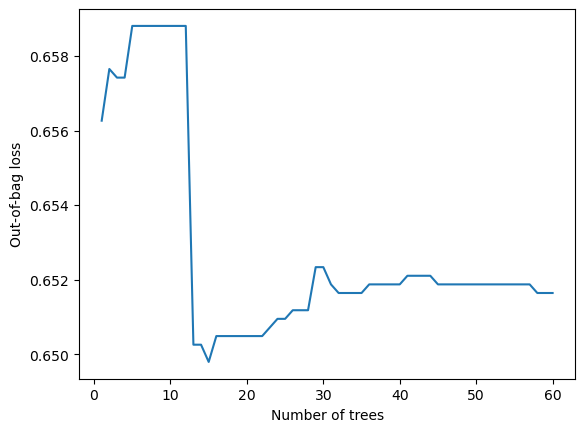

In [78]:
import matplotlib.pyplot as plt

logs = models['gbt_tune1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

In [76]:
evaluation

{'gbt_tune1': {'loss': 0.0, 'accuracy': 0.6493291854858398}}

In [29]:
evaluation

{'gbt_tune1': {'loss': 0.0, 'accuracy': 0.8242970108985901}}

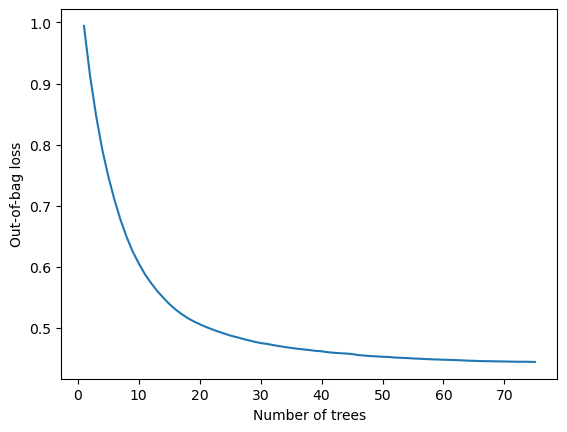

In [27]:
import matplotlib.pyplot as plt

logs = models['gbt_tune1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

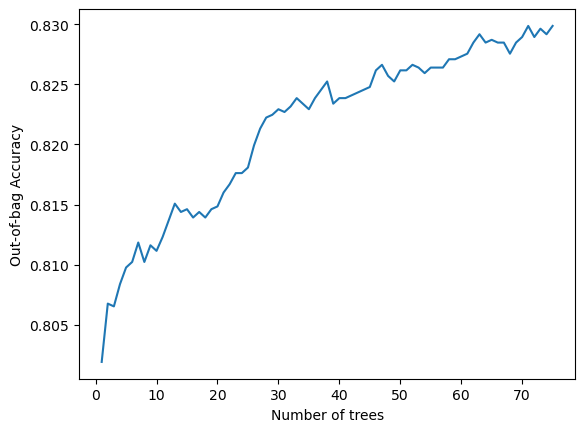

In [28]:
import matplotlib.pyplot as plt

logs = models['gbt_tune1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag Accuracy")
plt.show()

# Train on Entire Dataset


In [302]:
train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
# A more complex, but possibly, more accurate model.
models = {
    #'rf_baselines': tfdf.keras.RandomForestModel(),
    #'rf_tune1': tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION),
    #'gbt_baselines': tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION),
    'gbt_tune1': tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
    }

models['gbt_tune1'].compile(metrics=["accuracy"])
models['gbt_tune1'].fit(x=train_tf)

851/851 [==============================] - 1s 1ms/step


# Predictions

In [303]:
models

{'gbt_tune1': <tensorflow_decision_forests.keras.GradientBoostedTreesModel at 0x7fe71c57cc40>}

In [304]:
scores = models['gbt_tune1'].predict(predictions)

In [305]:
#Label classes: ['adoption', 'no outcome', 'transfer']

In [306]:
scores

array([[8.7180000e-04, 9.9736279e-01, 1.7653710e-03],
       [2.0946354e-02, 7.1948725e-01, 2.5956640e-01],
       [9.3595344e-01, 3.3668408e-03, 6.0679663e-02],
       ...,
       [3.3661008e-01, 3.5512988e-02, 6.2787688e-01],
       [9.6797407e-01, 6.9470480e-03, 2.5078943e-02],
       [1.5179572e-01, 8.3186381e-02, 7.6501787e-01]], dtype=float32)

In [307]:
temp = pd.DataFrame(data=scores, columns=["adoption", "no outcome","transfer"])

In [308]:
temp['id'] = submission.id

In [309]:
temp = temp[['id','adoption','no outcome','transfer']]

In [310]:
temp

,id,adoption,no outcome,transfer
0,67473,0.000872,0.997363,0.001765
1,4629,0.020946,0.719487,0.259566
2,13914,0.935953,0.003367,0.060680
3,53131,0.093944,0.219680,0.686376
4,57800,0.585817,0.039921,0.374262
...,...,...,...,...
23312,9347,0.903591,0.038790,0.057620
23313,3781,0.004891,0.022325,0.972784
23314,74693,0.336610,0.035513,0.627877
23315,44987,0.967974,0.006947,0.025079


In [311]:
temp['no outcome'] = np.where(temp['no outcome'] > .96, 1, temp['no outcome'])
temp['adoption'] = np.where(temp['no outcome'] == 1, 0, temp['adoption'])
temp['transfer'] = np.where(temp['no outcome'] == 1, 0, temp['transfer'])

In [312]:
temp['adoption'] = np.where(temp['adoption'] > .96, 1, temp['adoption'])
temp['no outcome'] = np.where(temp['adoption'] == 1, 0, temp['no outcome'])
temp['transfer'] = np.where(temp['adoption'] == 1, 0, temp['transfer'])

In [313]:
temp['transfer'] = np.where(temp['transfer'] > .96, 1, temp['transfer'])
temp['adoption'] = np.where(temp['transfer'] == 1, 0, temp['adoption'])
temp['no outcome'] = np.where(temp['transfer'] == 1, 0, temp['no outcome'])

In [314]:
temp.to_csv('submission.csv', index=False)

In [316]:
!kaggle competitions submit -c sliced-s01e10-playoffs-2 -f submission.csv -m "Best With Names with outcome updates"

100%|█████████████████████████████████████████| 779k/779k [00:00<00:00, 850kB/s]
400 - Bad Request
